# Covid-19

This is an exploratory notebook that leverages Partnership data. We are guided by the suggestions and pointers given in our meetings on the subjects with experts across the Bank and external partners.

## Setup

If you are running ddp code for the first time, you need to install the library that includes many helper functions to easy access to partner data.

You need to be a added to the [Github repository](https://github.com/datapartnership/devdatapartnership) to get access. If you cannot see it, you don't have access to install the library. If so, please contact datapartnership@worldbank.org with your Github username to get added to the repository.

```sh
conda create -n ddp python=3
conda activate ddp
/path/to/python -m pip install -e git+ssh://git@github.com/datapartnership/devdatapartnership.git#egg=devdatapartnership
```
Note: You need to restart the kernel to be able to import after install

In [1]:
#import sys ; sys.executable

### Authenticate using DDP credentials


In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
env_path = Path('~/')/'.ddp' / '.env'
load_dotenv(dotenv_path=env_path)
load_dotenv(override=True);
MAPBOX_ACCESS_TOKEN = os.getenv("MAPBOX_ACCESS_TOKEN")

## Accesibility to health facilities

This section explores who to measure accesibility, in minutes, to health facilities. 

We will assume that a region needs to know how far away (by car) their entire population is from their closest hospital. You can use this to see regions that are too far away, or where to locate additional services that cater those most in need.

### Routing engine

One of our partners, Mapbox, offers traffic-aware global travel times. We will set up the functions to calculate distance in km and minutes.

In [2]:
#Simple point to point call

import requests  #http framework to make Mapbox API requests for routes
import json # handle response as json
import datetime # save timestamp

osrm_server="https://api.mapbox.com/directions-matrix/v1/mapbox/"
modes=['driving-traffic', 'driving', 'cycling', 'walking']
mode = modes[0]
url=osrm_server+mode+'/'
params="?annotations=distance,duration&access_token="+MAPBOX_ACCESS_TOKEN
comma="%2C"
sep="%3B"

origin=[43.394020,-5.706718]
destination=[43.523757,-6.047233]
fullurl=url+str(origin[1])+','+str(origin[0])+";"+str(destination[1])+','+str(destination[0])+params
response = requests.get(fullurl) #do the request
response.raise_for_status() # ensure we notice bad responses
response=json.loads(response.text)
#print(response)
print, fullurl
print("Entre La Corrada y Noreña hay %2.1f km y ~%2.0f minutos en coche"%
      (response['distances'][0][1]/1000.,
       response['durations'][0][1]/60.))

Entre La Corrada y Noreña hay 49.8 km y ~36 minutos en coche


### Data we need

1. Origins: From where to start to travel time (population centers, zip codes, cities, ...)
2. Population on origins: How many people are located at the origin?
3. Destinations: The set of destinations. Health facilities in this case

In our case, as a proxy for 1. and 2. we will use our partner Facebook and their [population density map](https://data.humdata.org/dataset/highresolutionpopulationdensitymaps).

For 3 we use the hospitals and health centers tagged as such on OSM (using e.g. [overpass-turbo](https://overpass-turbo.eu/s/Rlq))

We choose Algeria, as they are the developing country with highest known cases


#### Population density

Population Density maps are **huge** files where every pixel is ~23m^2. To manage the computation our strategy is to first cluster the country in windows of size e.g. `2000 pixels`. If the window has no population inside, we skip. If it does be split the window in 4 sub-windows, and repeat the process until the window has an arbitraty minimum size e.g. `500 pixels`.

In [75]:
location='Senegal'
pop_density_url="https://data.humdata.org/dataset/dbd7b22d-7426-4eb0-b3c4-faa29a87f44b/resource/f84782aa-b726-4370-91cc-9bca318ee067/download/population_sen_2018-10-01.zip"

In [77]:
#Get the data
import urllib

print("Getting %s population data"%(location) )
data_folder=Path('.')/'data'/location
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

pop_file=data_folder/'pop_density/'
if not os.path.exists(pop_file.with_suffix('.zip')):
    print("Downloading pop density")
    urllib.request.urlretrieve (pop_density_url,pop_file.with_suffix('.zip'))
if not os.path.exists(pop_file):
    print("Unzipping pop density")
    urllib.request.urlretrieve (pop_density_url,pop_file)

#TODO get this file
map_file=pop_file/'population_sen_2018-10-01.tif'
print("Map file: %s"%map_file)

Getting Senegal population data
Map file: data/Senegal/pop_density/population_sen_2018-10-01.tif


In [61]:
import numpy as np
import rasterio
import pandas as pd
from rasterio.windows import Window
from matplotlib import pyplot


def get_pop(map_file,left_x,top_y,window,plot=False):
    """
    get_pop(raster filename,left_x,top_y,window,plot=False)
    
    Given a raster file, and row,cols ranges,
    return the lonlat of the ranges, nancount, and the nunsum
    
    Optionally plot the raster window [False]
    """
    right_x,bottom_y = left_x + window, top_y + window
    with rasterio.open(map_file) as src:
        left_lon, top_lat = src.xy(top_y,left_x )
        right_lon, bottom_lat = src.xy(bottom_y, right_x )
        center_lon , center_lat = (right_lon + left_lon)/2., (top_lat+bottom_lat)/2.
                             #Window(col_off, row_off, width, height)
        w = src.read(1, window=Window(left_x, top_y, window, window))
        if plot:
            pyplot.imshow(w, cmap='pink')
            pyplot.show()
        nancount=np.count_nonzero(~np.isnan(w))
        count = np.size(w)
        tot_pop=np.nansum(w)
    if count == 0:
        return {} #Out of bounds
    if tot_pop == 0 or window < 100:
        split=False
    else:
        split=True
    out={'window':window,
         'left_x':left_x,
         'right_x':right_x,
         'top_y':top_y,
         'bottom_y':bottom_y,
         'left_lon':left_lon, 
         'top_lat':top_lat, 
         'right_lon':right_lon,
         'bottom_lat':bottom_lat,
         'center_lon':center_lon , 
         'center_lat':center_lat,
         'count': count,
         'nancount':nancount,
         'tot_pop':tot_pop,
         'split': split}
    return out

In [78]:
#Scan the raster map with big windows
origins=pd.DataFrame()
window=2000
for left_x in np.arange(0,pop.width,window):
    for top_y in np.arange(0,pop.height,window):
        out=get_pop(map_file,left_x,top_y,window,plot=False)
        if out != {}:
            origins=origins.append([out])
    print("%i/%i\r"%(left_x,pop.width),end="")

In [72]:
def split(map_file,origin,plot=False):
    """
    Split a window row in 4 parts, and return new rows results
    """
    origins=pd.DataFrame()
    
    window=int(origin.window/2)
    for left_x in np.arange(origin.left_x,origin.right_x,window):
        for top_y in np.arange(origin.top_y,origin.bottom_y,window):
            out=get_pop(map_file,left_x,top_y,window,plot=plot)
            if out != {}:
                origins=origins.append([out])
    return origins

In [80]:
#Do a splitting pass
#run this cell as many times as you want to split the windows
print("%i windows need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("We now have %i windows, %i will be split in next round"%(len(origins),len(origins[origins['split']==True])))
origins

268 windows need splitting
We now have 1462 windows, 926 will be split in next round


,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split
0,2000,0,2000,0,2000,-17.529167,16.690833,-16.973611,16.135278,-17.251389,16.413056,4000000,0,0.000000e+00,False
0,2000,0,2000,2000,4000,-17.529167,16.135278,-16.973611,15.579722,-17.251389,15.857500,4000000,0,0.000000e+00,False
0,2000,0,2000,4000,6000,-17.529167,15.579722,-16.973611,15.024167,-17.251389,15.301944,4000000,264,2.521944e+03,done
0,2000,0,2000,6000,8000,-17.529167,15.024167,-16.973611,14.468611,-17.251389,14.746389,4000000,139537,3.885435e+06,done
0,2000,0,2000,8000,10000,-17.529167,14.468611,-16.973611,13.913056,-17.251389,14.190833,4000000,12268,1.243638e+05,done
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,500,22000,22500,13500,14000,-11.418056,12.940833,-11.279167,12.801944,-11.348611,12.871389,79000,169,1.567722e+03,True
0,500,22000,22500,14000,14500,-11.418056,12.801944,-11.279167,12.663056,-11.348611,12.732500,79000,7,6.493522e+01,True
0,500,22000,22500,14500,15000,-11.418056,12.663056,-11.279167,12.524167,-11.348611,12.593611,79000,0,0.000000e+00,False
0,500,22000,22500,15000,15500,-11.418056,12.524167,-11.279167,12.385278,-11.348611,12.454722,79000,57,5.287582e+02,True


#### Hospital destination

In [5]:
hospitals_file=data_folder/'hospitals.geojson'
print("Destination file: %s"%hospitals_file)

Destination file: data/Senegal/hospitals.geojson


/Users/brunosan/anaconda3/envs/p3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


There are 292 hospital destinations


,id,@id,amenity,healthcare,type,landuse,name,emergency,area,operator,...,name_es_1,addr_ful_1,electric_1,health_a_1,staff_co_2,staff_co_3,water_so_1,geometry,lat,lon
0,relation/1753787,relation/1753787,hospital,hospital,multipolygon,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT (-1738583.229 1329486.757),11.857425,-15.617959
1,relation/5386723,relation/5386723,hospital,None,multipolygon,military,Hôpital Militaire de Ouakam,None,None,None,...,None,None,None,None,None,None,None,POINT (-1945955.898 1656377.750),14.715010,-17.480819
2,relation/5411079,relation/5411079,hospital,None,multipolygon,None,Centre de Santé de Diofior,yes,None,None,...,None,None,None,None,None,None,None,POINT (-1854637.212 1594740.067),14.178820,-16.660490
3,relation/5605265,relation/5605265,hospital,None,multipolygon,None,Hôpital de la Paix,yes,None,None,...,None,None,None,None,None,None,None,POINT (-1811869.187 1410470.759),12.568447,-16.276298
4,relation/5637352,relation/5637352,hospital,hospital,multipolygon,None,Hospital Nacional Simão Mendes,yes,yes,Ministerio di Saude,...,None,None,None,None,None,None,None,POINT (-1734433.543 1330163.415),11.863374,-15.580682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,node/7036645308,node/7036645308,hospital,None,None,None,Poste de santé,None,None,Mairie,...,None,None,None,None,None,None,None,POINT (-1778563.649 1440919.798),12.835282,-15.977109
288,node/7066446186,node/7066446186,hospital,None,None,None,Poste de santé ser igne mouhamadou Moustapha M...,None,None,None,...,None,None,None,None,None,None,None,POINT (-1768001.934 1674805.169),14.875058,-15.882232
289,node/7151547934,node/7151547934,hospital,hospital,None,None,stop step pharmacy,None,None,None,...,None,None,None,None,None,None,None,POINT (-1864093.620 1505090.813),13.396699,-16.745438
290,node/7237319798,node/7237319798,hospital,hospital,None,None,None,None,None,None,...,None,None,None,None,None,None,None,POINT (-1819885.556 1729249.359),15.347225,-16.348310


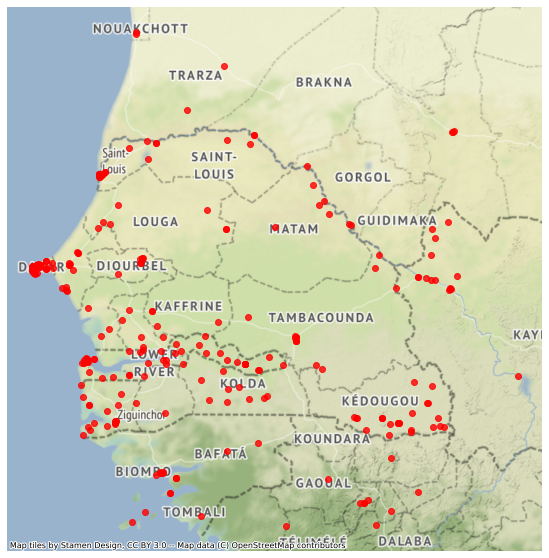

In [113]:
import contextily as ctx
import geopandas as gpd

hospitals = gpd.read_file(hospitals_file).to_crs('epsg:3857')
hospitals['lat']=hospitals.to_crs("epsg:4327").geometry.y
hospitals['lon']=hospitals.to_crs("epsg:4327").geometry.x

ax = hospitals.plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax)
ax.set_axis_off()
print("There are %i hospital destinations"%len(hospitals))
hospitals

In [130]:
hospitals=hospitals.sample(frac=1).head(10)
origins=origins.sample(frac=1).head(10)

In [131]:

hospitals_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitals[['lat','lon']].values])
hospitals_loc

'-17.48081925274125,14.715009599999991;-15.617958876652573,11.857425249999995'

In [135]:
buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

batch=3
origen_tipo='hospital'
origins['t_'+origen_tipo]=-1
origins['m_'+origen_tipo]=-1

for i in np.arange(origins.shape[0]/batch)[0:10]:
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    lugares_batch=origins.iloc[int(batch*i):].head(n=batch)
    
    destinos=";".join([str(i[1])+','+str(i[0]) for i in lugares_batch[['center_lat','center_lon']].values])
    destinos_nombre=lugares_batch.index
    
    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(lugares_batch))])

    fullurl= url+hospitals_loc+";"+destinos+trail+params

    print(fullurl)
    response = requests.get(fullurl)
    response.raise_for_status()
    duraciones_matrix=json.loads(response.text)['durations']
    duraciones=[]
    hospital_min=[]
    for origen in np.arange(np.shape(duraciones_matrix)[0]):
        duraciones+=[min(duraciones_matrix[origen])]
        hospital_min+=[np.argmin(duraciones_matrix[origen])]
    for i in np.arange(len(duraciones)):
        origins.loc[[destinos_nombre[i]], ['t_'+origen_tipo]]=buffer+duraciones[i]/60./60.*overalpenalty
        origins.loc[[destinos_nombre[i]], ['m_'+origen_tipo]]=hospital_min[i]

https://api.mapbox.com/directions-matrix/v1/mapbox/driving-traffic/-17.48081925274125,14.715009599999991;-15.617958876652573,11.857425249999995;-13.431944444444442,15.37138888888889;-14.681944444444444,12.59361111111111;-11.556944444444444,12.940833333333334.json?destinations=0;1&sources=2;3;4?annotations=distance,duration&access_token=pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg
https://api.mapbox.com/directions-matrix/v1/mapbox/driving-traffic/-17.48081925274125,14.715009599999991;-15.617958876652573,11.857425249999995;-17.043055555555554,15.093611111111112;-14.126388888888886,14.676944444444445;-14.681944444444444,14.954722222222223.json?destinations=0;1&sources=2;3;4?annotations=distance,duration&access_token=pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg
https://api.mapbox.com/directions-matrix/v1/mapbox/driving-traffic/-17.48081925274125,14.715009599999991;-15.617958876652573,11.857425249999995;-12.112499999999997,14.051944444444445;-16.2

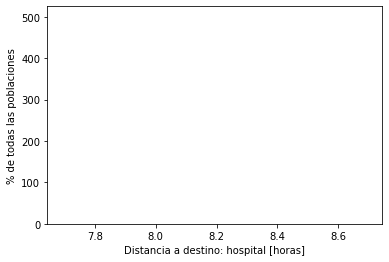

In [133]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
origins['t_'+origen_tipo].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% de todas las poblaciones')
plt.xlabel('Distancia a destino: '+origen_tipo+' [horas]')
plt.show()

In [134]:
origins

,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,t_hospital,m_hospital
0,500,14500,15000,4500,5000,-13.501389,15.440833,-13.362500,15.301944,-13.431944,15.371389,250000,21,199.525875,True,8.193975,1
0,500,10000,10500,14500,15000,-14.751389,12.663056,-14.612500,12.524167,-14.681944,12.593611,250000,0,0.000000,False,8.193975,1
0,1000,21000,22000,13000,14000,-11.695833,13.079722,-11.418056,12.801944,-11.556944,12.940833,1000000,853,7912.820188,done,8.193975,1
0,500,1500,2000,5500,6000,-17.112500,15.163056,-16.973611,15.024167,-17.043056,15.093611,250000,264,2521.943986,True,8.193975,1
0,500,12000,12500,7000,7500,-14.195833,14.746389,-14.056944,14.607500,-14.126389,14.676944,250000,45,291.122484,True,8.193975,1
0,500,10000,10500,6000,6500,-14.751389,15.024167,-14.612500,14.885278,-14.681944,14.954722,250000,461,2982.388113,True,8.193975,1
0,1000,19000,20000,9000,10000,-12.251389,14.190833,-11.973611,13.913056,-12.112500,14.051944,1000000,418,6588.042663,done,8.193975,1
0,500,4500,5000,9000,9500,-16.279167,14.190833,-16.140278,14.051944,-16.209722,14.121389,250000,2246,28379.626910,True,8.193975,1
0,1000,11000,12000,3000,4000,-14.473611,15.857500,-14.195833,15.579722,-14.334722,15.718611,1000000,960,8017.442525,done,8.193975,1
0,500,14000,14500,13000,13500,-13.640278,13.079722,-13.501389,12.940833,-13.570833,13.010278,250000,25,233.401512,True,8.193975,1
